## Data preparation and infrastructure exposure to flooding

This notebook forms the basis of "Hands-On 5" in the CCG course.

1. Extract infrastructure data from OpenStreetMap
2. Extract flood hazard data from Aqueduct
3. Intersect floods with roads to calculate exposure
4. Open QGIS to look at the data

In [25]:
# The os and subprocess modules are built into Python
# see https://docs.python.org/3/library/os.html
import os

# see https://docs.python.org/3/library/subprocess.html
import subprocess

# see https://docs.python.org/3/library/time.html
import time

# see https://docs.python.org/3/library/pathlib.html
from pathlib import Path

### Activity 1: Extract infrastructure data

#### Step 1) On your desktop, create a folder called `ghana_tutorial`

#### Step 2) Create a variable to store the folder location

In the cell below, type in the path to your desktop, by changing NAME to match your username as shown on your computer

In [26]:
# edit this if using a Mac (otherwise delete)
data_folder = Path("YOUR_PATH/ghana_tutorial")

# edit this if using Windows (otherwise delete)
# data_folder = Path("C:YOUR_PATH/ghana_tutorial")

# delete this line
# data_folder = Path("../data")

### Step 3) Load Python libraries

In [27]:
# Pandas and GeoPandas are libraries for working with datasets
# see https://geopandas.org/
import geopandas as gpd

gpd._compat.USE_PYGEOS = False
# see https://pandas.pydata.org/
import pandas as pd

# This package interacts with a risk data extract service, also accessible at
# https://global.infrastructureresilience.org/downloads
import irv_autopkg_client

# We'll use snail to intersect roads with flooding
import snail.intersection
import snail.io

# snkit helps generate connected networks from lines and nodes
# see https://snkit.readthedocs.io/
import snkit
import snkit.network

# PyPROJ is a library for working with geographic projections
# see https://pyproj4.github.io/
from pyproj import Geod

from matplotlib import pyplot as plt

#### Step 4) and 5) Download and save data

Download the `ghana-latest-free.shp.zip` dataset from http://download.geofabrik.de/africa/ghana.html, extract the zip folder and save the extracted folder within your new folder `ghana_tutorial`

#### Step 6) Load the road dataset you've just downloaded

In [28]:
roads = gpd.read_file(
    data_folder / "ghana-latest-free" / "gis_osm_roads_free_1.shp"
)

#### Step 7) To take a look at the data and the attribute table fill in and run the next two cells

In [29]:
roads.head(5)

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry
0,4790591,5121,unclassified,Airport Road,None,B,0,0,F,F,"LINESTRING (-0.17184 5.60847, -0.17182 5.60849..."
1,4790592,5122,residential,Nortei Ababio Road,None,B,0,0,F,F,"LINESTRING (-0.18282 5.61197, -0.18336 5.61198..."
2,4790594,5115,tertiary,Airport Road,None,F,0,0,F,F,"LINESTRING (-0.17544 5.60550, -0.17418 5.60555..."
3,4790596,5121,unclassified,Airport Road,None,F,0,0,F,F,"LINESTRING (-0.17207 5.60853, -0.17207 5.60844..."
4,4790597,5122,residential,Volta Road,None,B,0,0,F,F,"LINESTRING (-0.18282 5.61197, -0.18280 5.61262..."


In [30]:
roads.fclass.unique()

array(['unclassified', 'residential', 'tertiary', 'tertiary_link',
       'secondary', 'trunk', 'service', 'primary', 'motorway_link',
       'trunk_link', 'primary_link', 'secondary_link', 'footway', 'path',
       'track', 'motorway', 'track_grade3', 'track_grade4', 'steps',
       'pedestrian', 'bridleway', 'cycleway', 'track_grade2',
       'track_grade5', 'track_grade1', 'living_street', 'busway'],
      dtype=object)

#### Step 8) Next we want to make a couple of changes to the data

Filter out minor and residential roads, tracks and paths.

In [31]:
# Keep only the specified columns
roads = roads[["osm_id", "fclass", "name", "geometry"]]
# Keep only the roads whose "fclass" is in the list
roads = roads[
    roads.fclass.isin(
        [
            "motorway",
            "motorway_link",
            "trunk",
            "trunk_link",
            "primary",
            "primary_link",
            "secondary",
            "secondary_link",
            "tertiary",
            "tertiary_link",
        ]
    )
]
# Rename some columns
roads = roads.rename(
    columns={
        "fclass": "road_type",
    }
)

Create topological network information - this adds information that will let us find routes over the road network.
- add nodes at the start and end of each road segment
- split roads at junctions, so each segment goes from junction to junction
- add ids to each node and edge, and add `from_id` and `to_id` to each edge

In [32]:
road_network = snkit.Network(edges=roads)

In [33]:
with_endpoints = snkit.network.add_endpoints(road_network)
split_edges = snkit.network.split_edges_at_nodes(with_endpoints)
with_ids = snkit.network.add_ids(
    split_edges, id_col="id", edge_prefix="roade", node_prefix="roadn"
)
connected = snkit.network.add_topology(with_ids)
roads = connected.edges
road_nodes = connected.nodes

Calculate the length of each road segment in meters

In [34]:
geod = Geod(ellps="WGS84")
roads["length_m"] = roads.geometry.apply(geod.geometry_length)

In [35]:
roads.tail(5)

,osm_id,road_type,name,geometry,id,from_id,to_id,length_m
15992,1290190247,tertiary_link,None,"LINESTRING (-0.12481 5.74521, -0.12490 5.74498)",roade_15992,roadn_12502,roadn_12503,27.700205
15993,1290190248,tertiary_link,None,"LINESTRING (-0.13500 5.74826, -0.13501 5.74795)",roade_15993,roadn_12504,roadn_12505,33.975731
15994,1290190251,tertiary,None,"LINESTRING (-0.12720 5.74611, -0.12490 5.74498)",roade_15994,roadn_10570,roadn_12503,283.569056
15995,1290190251,tertiary,None,"LINESTRING (-0.12490 5.74498, -0.12394 5.74449...",roade_15995,roadn_12503,roadn_12506,888.391459
15996,1290190252,tertiary_link,None,"LINESTRING (-0.14601 5.74863, -0.14594 5.74867...",roade_15996,roadn_12507,roadn_12508,39.078872


In [36]:
roads.set_crs(4326, inplace=True)
road_nodes.set_crs(4326, inplace=True)
road_nodes.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Text(170.1578223077743, 0.5, 'Latitude [deg]')

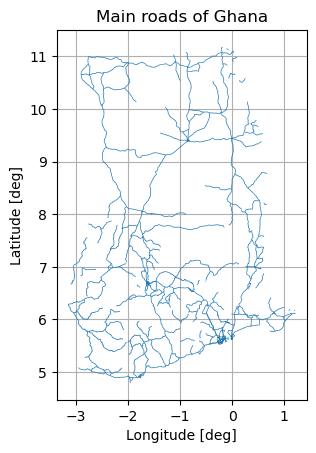

In [37]:
main_roads = roads[roads["road_type"].isin(["trunk","secondary",])]

f, ax = plt.subplots()

main_roads.plot(
    ax=ax,
    alpha=1,
    linewidth=0.5,
)

ax.grid()
ax.set_title("Main roads of Ghana")
ax.set_xlabel("Longitude [deg]")
ax.set_ylabel("Latitude [deg]")

#### Step 9) Save the pre-processed dataset

In [38]:
roads.to_file(
    data_folder / "GHA_OSM_roads.gpkg",
    layer="edges",
    driver="GPKG",
)
road_nodes.to_file(
    data_folder / "GHA_OSM_roads.gpkg",
    layer="nodes",
    driver="GPKG",
)

### Activity 2: Extract hazard data


The full [Aqueduct dataset](https://www.wri.org/resources/data-sets/aqueduct-floods-hazard-maps) is available to download openly. 

Country-level extracts are available through the [Global Systemic Risk Assessment Tool (G-SRAT)](https://global.infrastructureresilience.org/downloads/). This section uses that service to download an extract for Ghana.

In [39]:
country_iso = "gha"

Create a client to connect to the data API:

In [40]:
client = irv_autopkg_client.Client()

In [41]:
job_id = client.job_submit(country_iso, ["wri_aqueduct.version_2"])

In [42]:
while not client.job_complete(job_id):
    print("Processing...")
    time.sleep(1)

Processing...


In [43]:
client.extract_download(
    country_iso,
    data_folder / "flood_layer",
    # there may be other datasets available, but only download the following
    dataset_filter=["wri_aqueduct.version_2"],
    overwrite=True,
)

#### Alternative: download flood hazard data from Aqueduct

The full [Aqueduct dataset](https://www.wri.org/resources/data-sets/aqueduct-floods-hazard-maps) is available to download. There are some scripts and summary of the data you may find useful at [nismod/aqueduct](https://github.com/nismod/aqueduct).

There are almost 700 files in the full Aqueduct dataset, of up to around 100MB each, so we don't recommend downloading all of them unless you intend to do further analysis.

The next steps show how to clip a region out of the global dataset, in case you prefer to work from the original global Aqueduct files.

To follow this step, we suggest downloading [inunriver_historical_000000000WATCH_1980_rp00100.tif](http://wri-projects.s3.amazonaws.com/AqueductFloodTool/download/v2/inunriver_historical_000000000WATCH_1980_rp00100.tif) to work through the next steps. Save the downloaded file in a new folder titled `flood_layer` under your data_folder.

In [44]:
xmin = "-3.262509"
ymin = "4.737128"
xmax = "1.187968"
ymax = "11.162937"

for root, dirs, files in os.walk(os.path.join(data_folder, "flood_layer")):
    print("Looking in", root)
    for file_ in sorted(files):
        if file_.endswith(".tif") and not file_.endswith(
            f"-{country_iso}.tif"
        ):
            print("Found tif file", file_)
            stem = file_[:-4]
            input_file = os.path.join(root, file_)

            # Clip file to bounds
            clip_file = os.path.join(
                root,
                "gha",
                "wri_aqueduct_version_2",
                f"{stem}-{country_iso}.tif",
            )
            try:
                os.remove(clip_file)
            except FileNotFoundError:
                pass
            cmd = [
                "gdalwarp",
                "-te",
                xmin,
                ymin,
                xmax,
                ymax,
                input_file,
                clip_file,
            ]
            print(cmd)
            p = subprocess.run(cmd, capture_output=True)
            print(p.stdout.decode("utf8"))
            print(p.stderr.decode("utf8"))
            print(clip_file)

Looking in /Users/ivannschlosser/Documents/oxford/ghana_tutorial/flood_layer
Looking in /Users/ivannschlosser/Documents/oxford/ghana_tutorial/flood_layer/gha
Looking in /Users/ivannschlosser/Documents/oxford/ghana_tutorial/flood_layer/gha/wri_aqueduct_version_2


### Activity 3: Intersect hazard 

Let us now intersect the hazard and the roads, starting with one hazard initially so we save time.

#### Step 1) Specify your input and output path as well as the name of the intersection

In [45]:
flood_path = Path(
    data_folder,
    "flood_layer",
    "gha",
    "wri_aqueduct_version_2",
    "inunriver_historical_000000000WATCH_1980_rp00100-gha.tif",
)

output_path = Path(
    data_folder,
    "results",
    "inunriver_historical_000000000WATCH_1980_rp00100__roads_exposure.gpkg",
)

Read in pre-processed road edges, as created earlier.

In [46]:
roads = gpd.read_file(data_folder / "GHA_OSM_roads.gpkg", layer="edges")

#### Step 2) Run the intersection

In [ ]:
grid, bands = snail.io.read_raster_metadata(flood_path)

prepared = snail.intersection.prepare_linestrings(roads)
flood_intersections = snail.intersection.split_linestrings(prepared, grid)
flood_intersections = snail.intersection.apply_indices(
    flood_intersections, grid
)
flood_data = snail.io.read_raster_band_data(flood_path)
flood_intersections[
    "inunriver__epoch_historical__rcp_baseline__rp_100"
] = snail.intersection.get_raster_values_for_splits(
    flood_intersections, flood_data
)

Calculate the exposed length

In [48]:
geod = Geod(ellps="WGS84")
flood_intersections["flood_length_m"] = flood_intersections.geometry.apply(
    geod.geometry_length
)

In [49]:
flood_intersections.tail(2)

,osm_id,road_type,name,id,from_id,to_id,length_m,geometry,split,index_i,index_j,inunriver__epoch_historical__rcp_baseline__rp_100,flood_length_m
15995,1290190251,tertiary,None,roade_15995,roadn_12503,roadn_12506,888.391459,"LINESTRING (-0.12490 5.74498, -0.12394 5.74449...",0,377,650,0.0,888.391459
15996,1290190252,tertiary_link,None,roade_15996,roadn_12507,roadn_12508,39.078872,"LINESTRING (-0.14601 5.74863, -0.14594 5.74867...",0,374,650,0.0,39.078872


Calculate the proportion of roads in our dataset which are exposed to >=1m flood depths in this scenario

In [50]:
exposed_1m = flood_intersections[
    flood_intersections.inunriver__epoch_historical__rcp_baseline__rp_100 >= 1
]
exposed_length_km = exposed_1m.flood_length_m.sum() * 1e-3
exposed_length_km

765.1773274965389

In [51]:
all_roads_in_dataset_length_km = roads.length_m.sum() * 1e-3
all_roads_in_dataset_length_km

29441.60010046896

In [52]:
proportion = exposed_length_km / all_roads_in_dataset_length_km
proportion

0.0259896651297954

In [53]:
f"{proportion:.1%} of roads in this dataset are exposed to flood depths of >= 1m in a historical 1-in-100 year flood"

'2.6% of roads in this dataset are exposed to flood depths of >= 1m in a historical 1-in-100 year flood'

In [54]:
output_path.parent.mkdir(parents=True, exist_ok=True)

Save to file (with spatial data)

In [55]:
flood_intersections.to_file(output_path, driver="GPKG")

Save to CSV (without spatial data)

In [56]:
flood_intersections.drop(columns="geometry").to_csv(
    output_path.parent / output_path.name.replace(".gpkg", ".csv")
)